In [14]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli
print(grizli.__version__)

from grizli import utils as griz_utils

import pandas as pd
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

0.6.0-115-g3ce5ccf


In [3]:
flist = pd.read_pickle('../dataframes/file_list/41520.pkl')

In [20]:
files  =  list(np.append(flist.g102_file,flist.g141_file.values[0:4]))
info = griz_utils.get_flt_info(files)
visits, filters = griz_utils.parse_flt_files(info=info, uniquename=True)

goodss-11-bhj-11-230.0-G141 4
GS3-cxt-32-173.0-G102 4
GS3-cxt-33-173.0-G102 4
GS3-cxt-30-193.0-G102 4
GS3-cxt-31-193.0-G102 4
GS3-cxt-34-216.0-G102 4
GS3-cxt-35-216.0-G102 4


In [26]:
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

all_grism_files = []
for i in range(len(visits)):
    if '-g1' in visits[i]['product']:
        all_grism_files.extend(visits[i]['files'])
        
grp = GroupFLT(grism_files=files, direct_files=[], 
        ref_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
        seg_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
        catalog= hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',
    cpu_count=8)

Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
Image cutout: x=slice(5796, 11062, None), y=slice(12107, 17529, None)
Image cutout: x=slice(5781, 11047, None), y=slice(12107, 17529, None)
Image cutout: x=slice(5775, 11040, None), y=slice(12084, 17506, None)
Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
/Users/Vince.ec/Clear_data/s_flt_files/icxt30s0q_flt.fits / blot reference /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
Image cutout: x=slice(5796, 11062, None), y=slice(12107, 17529, None)
/Users/Vince.ec/Clear_data/s_flt_files/icxt30s5q_flt.fits / blot reference /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
/Users/Vince.ec/Clear_data/s_flt_files/icxt30s2q_flt.fits / blot reference /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
Image cutout: x=slice(5781, 11046, None), y=slice(12107, 17529, None)
/Users/Vince.ec/Clear_data/s_flt_files/

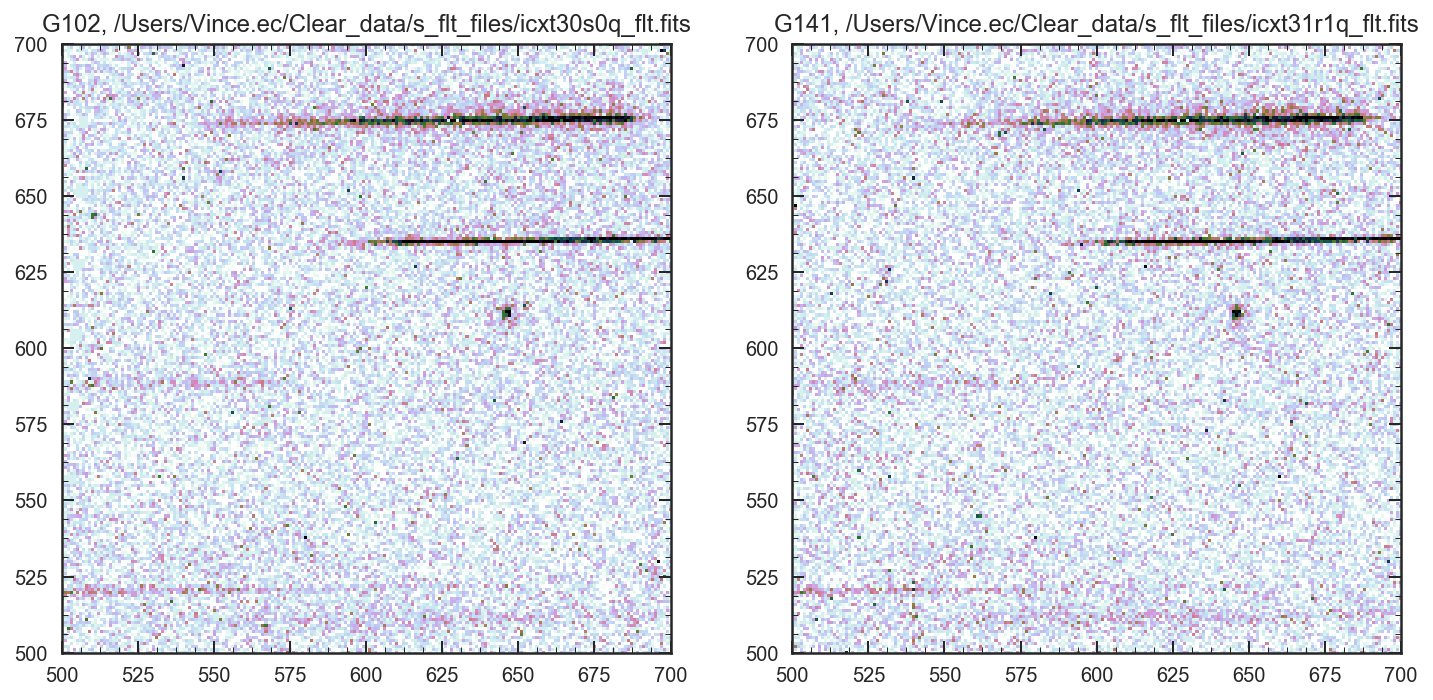

In [37]:

### Show FLT residuals### Show 
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121)
ax.imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G102, %s' %(grp.FLTs[0].grism.parent_file))

ax = fig.add_subplot(122)
ax.imshow(grp.FLTs[4].grism['SCI'] - grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G141, %s' %(grp.FLTs[4].grism.parent_file))

for ax in fig.axes:
    ax.set_xlim(500,700); ax.set_ylim(500,700)

In [39]:

## Fit parameters## Fit p 
pzfit, pspec2, pline = get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.5, 2.4]
pzfit['dz'] = [0.005, 0.0005]

# Drizzled line maps
pline = {'kernel': 'square', 'pixfrac': 0.6, 'pixscale': 0.06, 'size': 20}

# Full rectified 2D spectrum
pspec2 = {'NY': 20, 'dlam': 40, 'spatial_scale': 1}

In [41]:
id=41520
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

First iteration: z_best=1.6129

 Zoom iteration: z_best=1.6137



TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [74]:
g102_wave = list(mb.oned_spectrum()['G102']['wave'])
g141_wave = list(mb.oned_spectrum()['G141']['wave'])

In [80]:
IDX = [U for U in range(len(g102_wave)) if 8700< g102_wave[U] <11300]
IDC = [U for U in range(len(g141_wave)) if 11100< g141_wave[U] <16700]

<ErrorbarContainer object of 3 artists>

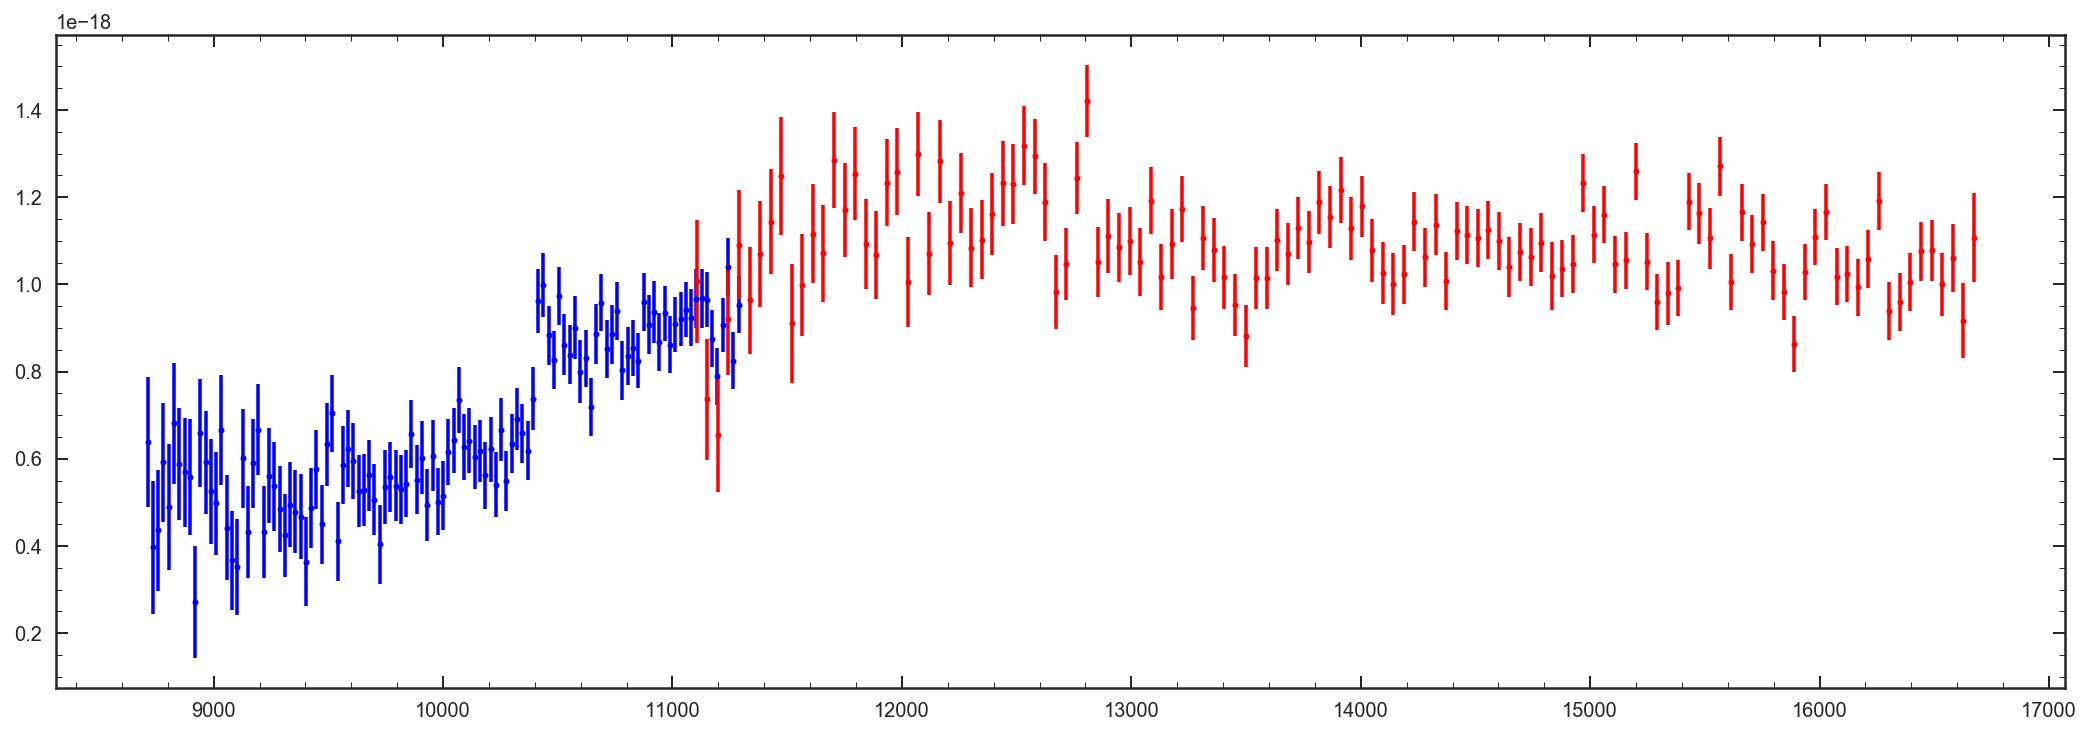

In [81]:
plt.figure(figsize=[18,6])
plt.errorbar(mb.oned_spectrum()['G102']['wave'][IDX],mb.oned_spectrum()['G102']['flux'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX],
             mb.oned_spectrum()['G102']['err'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX],
             linestyle='None', marker='o', markersize=3, color='b')
plt.errorbar(mb.oned_spectrum()['G141']['wave'][IDC],mb.oned_spectrum()['G141']['flux'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC],
            mb.oned_spectrum()['G141']['err'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC],
             linestyle='None', marker='o', markersize=3, color='r')


In [58]:
mb.oned_spectrum()['G102']

wave,flux,err,flat
Angstrom,ct / s,ct / s,Angstrom cm2 ct / erg
float64,float64,float64,float64
7700.0,0.0,0.0,0.0
7723.0,0.0,0.0,0.0
7746.0,0.0,0.0,0.0
7769.0,-0.0041270102266607505,0.0312280461555222,1.3421672973704278e+16
7792.0,0.018911925090525646,0.021297314068102455,1.5871447214542604e+16
7815.0,0.037488782102728914,0.019371587925181045,1.8882760683095308e+16
7838.0,-0.004356020078994011,0.01685327293950242,2.2445809239119748e+16
7861.0,0.0015539365394829571,0.01824260175872689,2.5809298806839516e+16
